If you like or fork this notebook, please upvote.

This notebook uses material from
* https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
* https://www.kaggle.com/mistyn/fast-ai-v3-lesson-1

This notebook is meant to be a basic introduction to tensors, PyTorch, and FastAI. It covers the following topics:
1. What is a tensor and why is it so useful for neural network training?
2. What are PyTorch data sets and models?
3. What are FastAI data sets and learners, and how do you use them in transfer learning?

In [ ]:
# These functions ensure that updates to the packages are reloaded as they occur
# And that any graphs that you produce are displayed inline in the jupyter notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
# PyTorch imports
import torch
print("torch version:", torch.__version__)
import torch.nn as nn
import torch.nn.functional as F

import torchvision   # Note there is an updated torchvision
print("torchvision version:", torchvision.__version__)
import torchvision.models as pytorch_models
import torchvision.datasets as pytorch_datasets

In [ ]:
# FastAI imports for vision applications
from fastai import *
from fastai.vision import *

# Tensors
A tensor is really a multi-dimensional data container which holds values of a specific type. 
For example, an MxN matrix of integers can be represented as a tensor.
However, tensors are dynamic, and will transform when interacting with other mathematical entities.

Tensors formed the basis of Tensorflow and the languages that have followed from it.
PyTorch is a second-generation tensor-based system. FastAI is implemented over PyTorch.

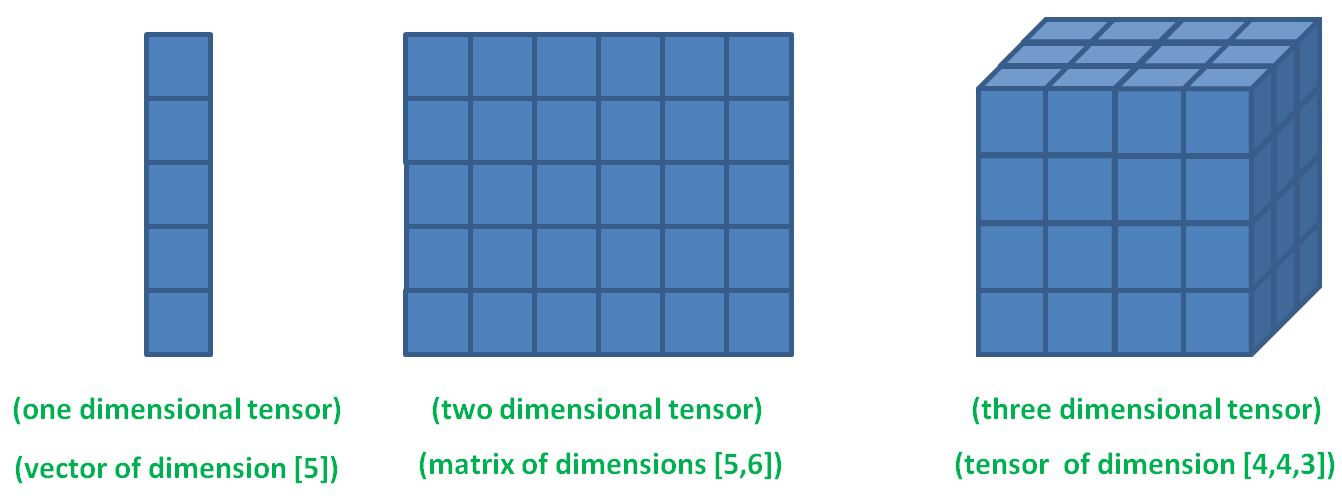

## Basics
You can make a PyTorch tensor from a numpy array

In [ ]:
a = np.ones([4,4])
b = torch.from_numpy(a)
print(b)

They do, however, share the same underlying representation

In [ ]:
np.add(a, 1, out=a)
print(b)

You can also create tensors directly

In [ ]:
c = torch.rand((4,4), dtype=torch.float64)
print(c)

You can add tensors and do other operations on them

In [ ]:
c + b

You can resize tensors

In [ ]:
print(c.size())
c_16 = c.view(16)
print(c_16.size())
c_8 = c.view(-1, 8)  # the size -1 is inferred from other dimensions
print(c_8.size())
print(c_8)

## Tensors and Neural Networks

Tensors apply so well in neural network models. A layer in a neural network transforms one tensor into a new tensor. So if we look at a typical neural network diagram we can veiw the weights at each layer as a tensor, the input data as a tensor, and the layer as a transforming operation

Resnet-34 Architecture

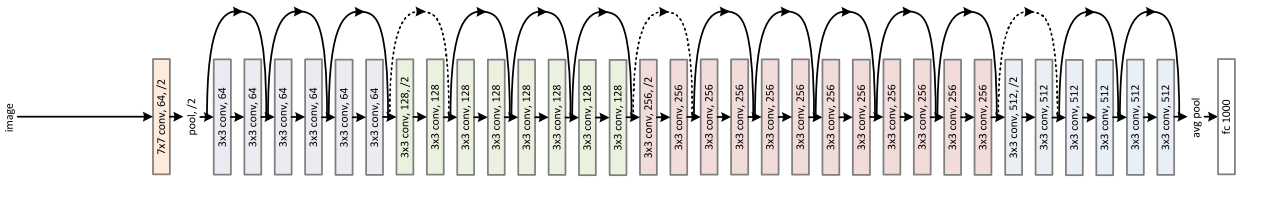
[https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf]

# Neural Network Models in PyTorch

### Autograd and Backpropagation
torch.Tensor is the class of tensors in PyTorch. 
If you set the attribute .requires_grad as True for a given tensor, it starts to track all operations on it. 
When you finish your computation you can call .backward() and have all the gradients computed automatically. 
The gradient for this tensor will be accumulated into .grad attribute.

Note that a vast majority of this section is taken directly from 
https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [ ]:
d = torch.rand(4, 4, requires_grad=True)
print(d)

In [ ]:
e = d * d * 3
f = e.mean()
print(f)

This means that when you define the model you only need to define the forward functions. PyTorch will automaically keep track of the backward functions.

You can use the requires_grad to block backpropagation when trying to freeze layers in pretrained models.

### Defining MNIST From Scratch
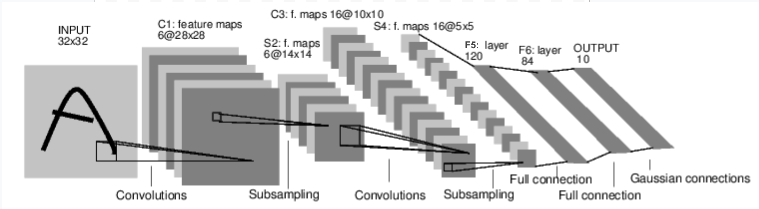

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

You can print the learnable parameters

In [ ]:
params = list(net.parameters())
print(params[0].size())

You can run the model forwards like this:

In [ ]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

### Loss Function

PyTorch nn package defines several different common loss functions. Here we use Mean Squared Error.

In [ ]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

We can follow the gradient functions back for a bit in the model to see what gradients are applied to the loss.

In [ ]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

### Backpropagation

In [ ]:
# Zero the gradient buffers of all parameters.
# This keeps them from accumulating with the older gradients
net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

# Using Predefined Models in PyTorch

PyTorch supports many different predefined models in its models package

In [ ]:
resnet34 = models.resnet34()
resnet34

You can also import a pretrained version from the torch.hub. The pretrained weights are stored in a file with the extension '.pth'. Note also that the name of the file is not just resnet34. The filename follows the naming convention modelname-<sha256>.ext where <sha256> is the first eight or more digits of the SHA256 hash of the contents of the file.

Note that this function copies the model weights into a cache. As you are using the pretrained model, the default location to find the weights is in the /tmp/.cache/torch/checkpoints/ directory.

In [ ]:
resnet34_pretrained = models.resnet34(pretrained=True)

You should be able to list the models, and describe individual models, though this appears to be broken at the moment

In [ ]:
# print(torch.hub.help('pytorch/vision', 'resnet34', force_reload=True))
# print(torch.hub.list('pytorch/vision', force_reload=True))

# Data in PyTorch

### DataSet

Data must be wrapped on a Dataset parent class. A dataset is a map from keys to data samples. This mapping is required for the loader to load the data, but does not actually load the data.

Required methods:
* \__getitem__ Returns the data sample and its label for a given key. It may apply transformations to the data along the way. Transformations may include things such as resizing, or converting the input to a tensor.
* \__len__ Returns the number of items in the training set X_train.
    


PyTorch already has a definition for the MNIST dataset.

In [ ]:
mnist_trainset = pytorch_datasets.MNIST(root='./data', train=True, download=True, 
                                        transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))])) # global mean and standard deviation of the MNIST dataset
print("Num MNIST training examples:", len(mnist_trainset))
mnist_testset = pytorch_datasets.MNIST(root='./data', train=False, download=True, 
                                       transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
print("Num MNIST test examples:", len(mnist_testset))
print(mnist_trainset)

PyTorch allows you to split your datasets into training and validation sets

In [ ]:
mnist_train, mnist_validation = torch.utils.data.random_split(mnist_trainset, (50000, 10000))
print(len(mnist_train), len(mnist_validation))

### DataLoader

The DataLoader effectively uses the DataSet as an iterator function and loads the data into memory. The batch_size defines how many examples are loaded at a time.

In [ ]:
train_dataloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
print(train_dataloader)
test_dataloader = DataLoader(mnist_testset, batch_size=64, shuffle=True)
print(test_dataloader)

In [ ]:
import matplotlib.pyplot as plt

examples = enumerate(test_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

# FastAI
Now that we understand the basics of PyTorch, let us look at a more complex example in FastAI.

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. 

Much of this was taken from https://www.kaggle.com/mistyn/fast-ai-v3-lesson-1

In [ ]:
path = untar_data(URLs.PETS)
path

In FastAI you can find out the information about a function using doc() or help()

In [ ]:
doc(untar_data)

In [ ]:
help(untar_data)

In FastAI you can do basic path manipulation very easily

In [ ]:
path.ls()

In [ ]:
path_anno = path/'annotations'
path_img = path/'images'

## Data in FastAI (DataBunch)
A FastAI DataBunch is the object that is used to feed a neural network. It collects together the following funcionality:
* The Fastai DataSet including the data items and their associated labels, as well as the standard and randomized transformations
  * Standard transformations apply to all data items uniformly, such as image resizing or conversion of the input to a tensor. They are computed on load
  * Random transformations are randomly applied to the item as it is presented as an example to the neural network.
* The DataLoader which allows us to feed the items to the neural network in batches

Note that a FastAI DataSet differs from a PyTorch DataSet in that it also includes information such as:
  * c -- represents the number of outputs of the final layer of your model. For a regression model, c=1. For a classification model, c is the number of classes
  * classes -- an enumerated list of the class labels for a classifier
  * loss_func -- a default loss function if your DataSet requires a specific loss function
  
The DataBunch is split into training set, validation set, and optional test set with consistent processing for all items across all sets

In [ ]:
batch_size=64

In [ ]:
fnames = get_image_files(path_img)
np.random.seed(2)
pat = re.compile(r'/([^/]+)_\d+.jpg$')
data = ImageDataBunch.from_name_re(path_img, 
                                   fnames, pat, 
                                   ds_tfms=get_transforms(), 
                                   size=224, 
                                   bs=batch_size, 
                                   num_workers=0
                                  ).normalize(imagenet_stats)
print("Classes:", data.classes)
print("Number of Classes:", len(data.classes),"=", data.c)

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

## Models and Learners in FastAI

FastAI uses the PyTorch models.

A Learner is the FastAI abstraction that takes a model, the data (as a DataBunch), a loss function (loss_func) and an optimizer such as Adam (opt_func). 
Trainer for model using data to minimize loss_func with optimizer opt_func.


In [ ]:
doc(cnn_learner)

We can use the PyTorch models in FastAI directly.

There are two parts to keep in mind when you are thinking about a model. When you use a model such as 'models.resnet34' you are actually referring to the **structure** of the model. This includes the layers of neural network nodes (with appropriate functions) as well as the connections between them.

If you do not use a pretrained model, the weights on the connections are initialized randomly. When you run create_cnn, you see that the default however is to use pretrained weights. The pretrained weights were computed as a result of training that data model over a large and relevant data set (for resnet models this is ImageNet). When you run create_cnn, the defaut also is to load the pretrained weights in the cache, so that any further training you do starts with these pretrained weights.

In [ ]:
# learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn

## Training Your model in FastAI

### Stage 1 Training

In this first round, we will just keep the pretrained weights frozen for the most part and just train by adjusting weights on the last layer.

Note that the freezing of the weights in FastAI by default does not freeze the weights in the BatchNormalization layers. Basically this is because batch normalization uses mean and standard deviation of the input data to smooth the optimizaiton space, and these values are data-specific. For a fuller explanation of this, see https://forums.fast.ai/t/why-are-batchnorm-layers-set-to-trainable-in-a-frozen-model/46560.

The fit_one_cycle function basically automates the learning rate, momentum and weight adjustments during training. It implements the policies defined in the paper "A Disciplined Approach to Neural Network
Hyper-Parameters: Part 1 – LEARNING RATE, Batch Size, Momentum, and Weight Decay" by Leslie Smith [https://arxiv.org/pdf/1803.09820.pdf](https://arxiv.org/pdf/1803.09820.pdf). See also this [Medium Article](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6).

In [ ]:
num_epochs = 4
learn.fit_one_cycle(num_epochs)

In [ ]:
# Save just in case we need to undo some training
learn.save('stage-1')

### Stage 1 Results

We will first see which were the categories that the model most confused with one another. 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

Plot the confusion matrix.

Note that the model makes the same mistakes over and over again but it rarely confuses other categories.

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

## Stage 2

A FastAI learner has a function to allow you to examine your learning rates with respect to how quickly you can reduce your loss during training. 

In [ ]:
learn.lr_find()

So the learn.recorder.plot gives learning rate vs. loss. We want to smooth this curve and look for the steepest point on the smoothed curve.

Here is an example of the plot. 
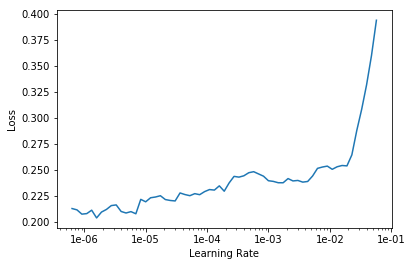

In [ ]:
learn.recorder.plot()

For the learning rate, we will adjust our lerning rate based on the new weights. If we look at the learning rate finder we see that the loss starts going up readily when it is larger than about 3e-01. We will back off from this a bit, and give a range for the finder to use that is about 3 orders of magnitude.

In [ ]:
num_epochs_2 = 2
max_lr_2 = slice(1e-6,1e-4)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(num_epochs_2, max_lr=max_lr_2)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)